<a href="https://colab.research.google.com/github/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/TorchCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File path: https://github.com/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/TorchCNN.ipynb

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
data_path = "./data/mnist/"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [0]:
def to_one_hot(x):
    b = np.zeros((len(x), 10))
    b[np.arange(len(x)), x] = 1
    return b

In [0]:
x_test = []
y_test = []

for data in test_loader:
    x_test.append(data[0].reshape(1, 28, 28).numpy())
    y_test.append(data[1][0])

y_test = torch.Tensor(to_one_hot(y_test))
x_test = torch.Tensor(x_test)

In [0]:
x_train = []
y_train = []

for data in test_loader:
    x_train.append(data[0].reshape(1, 28, 28).numpy())
    y_train.append(data[1][0])

y_train = torch.Tensor(to_one_hot(y_train))
x_train = torch.Tensor(x_train)

In [0]:
x_train = x_train[:5000]
x_test = x_test[:500]
y_train = y_train[:5000]
y_test = y_test[:500]

In [35]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(torch.min(x_test))
print(torch.max(x_test))

torch.Size([5000, 1, 28, 28]) torch.Size([500, 1, 28, 28]) torch.Size([5000, 10]) torch.Size([500, 10])
tensor(0.)
tensor(1.)


In [0]:
def plot_image(x):
    plt.imshow(x.reshape((28, 28)), cmap='gray')
    # plt.show()

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


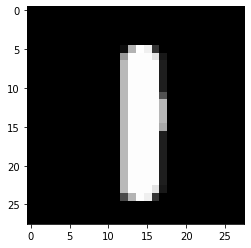

In [40]:
index = 12
plot_image(x_test[index].numpy())
print(y_test[index])
plt.show()

In [0]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

Params:
```yaml
input: (b, 1, 28, 28)

conv1:
    input: (b, 1, 28, 28)
    kernel_size: (3, 3)
    weights: (128, 3, 3)
    biases: 128
    stride: 1
    padding: 1
    output: (b, 128, 28, 28)
    activation: relu

conv2:
    input: (b, 128, 28, 28)
    kernel_size: (3, 3)
    weights: (256, 3, 3)
    biases: 256
    stride: 2
    padding: 1
    output: (b, 256, 14, 14)
    activation: relu

conv3:
    input: (b, 256, 14, 14)
    kernel_size: (3, 3)
    weights: (512, 3, 3)
    biases: 512
    stride: 2
    padding: 1
    output: (b, 512, 7, 7)
    activation: relu

fcc1:
    input: (b, 25088)
    weights: (25088, 1000)
    biases: 1000
    output: (b, 1000)
    activation: sigmoid

fcc2:
    input: (b, 1000)
    weights: (1000, 10)
    biases: 10
    output: (b, 10)
    activation: softmax

```

In [0]:
def pad2D(x):
    padded_x = torch.zeros((x.shape[0], x.shape[1], x.shape[2]+2, x.shape[3]+2))
    padded_x[:, :, 1:x.shape[2]+1, 1:x.shape[3]+1] = x
    return padded_x

In [63]:
class Conv2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=False):
        super(Conv2D, self).__init__()
        self.w = get_random((out_channels, in_channels * kernel_size * kernel_size))
        self.b = torch.ones(out_channels)
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x, **kwargs):
        if self.padding:
            x = pad2D(x)
        output = torch.zeros((x.shape[0], self.out_channels, (x.shape[2] - self.kernel_size) // self.stride + 1, (x.shape[3] - self.kernel_size) // self.stride + 1), requires_grad=True)  # (w - k +2p)/s + 1
        print(output.shape)
        row = x.shape[2]
        col = x.shape[3]
        for i in range(0, row - self.kernel_size + 1, self.stride):
            for j in range(0, col - self.kernel_size + 1, self.stride):
                cropped_x = x[:, :, i:i+self.kernel_size, j:j+self.kernel_size]
                h1 = cropped_x.reshape((-1, cropped_x.shape[1] * cropped_x.shape[2] * cropped_x.shape[3])).matmul(self.w.T) + self.b
                output[:, :, i // self.stride, j // self.stride] = h1
        return output

torch.Size([2, 2, 4, 4])


tensor([[[[1.2282, 1.1374, 1.3451, 1.2854],
          [1.3914, 1.7991, 1.1588, 0.8936],
          [1.2752, 0.9796, 0.9161, 0.6543],
          [1.5771, 1.6765, 1.7888, 1.3962]],

         [[1.3193, 1.9329, 1.2014, 1.6263],
          [1.7220, 2.0114, 1.9718, 1.7694],
          [1.2356, 1.9958, 1.9311, 1.8151],
          [2.0989, 2.1800, 2.1189, 1.7701]]],


        [[[1.1865, 1.0280, 1.2218, 1.1283],
          [1.4012, 1.1110, 1.0859, 0.8253],
          [0.8414, 1.4460, 0.9811, 1.2004],
          [1.2636, 1.5773, 2.0320, 1.1380]],

         [[1.5289, 1.7839, 2.0810, 1.6726],
          [1.6071, 2.2960, 2.0875, 1.9594],
          [1.6715, 1.9723, 2.0222, 1.5633],
          [1.3246, 1.9825, 1.5331, 1.7070]]]], grad_fn=<CopySlices>)

In [0]:
class Classifier (torch.nn.Module):
    def __init__(self):
        self.w1 = None
